This notebook is used to do a main model run

# Complex Different Effects Model

**What's different about this model compared to v1?**

Switched from a centered to a non-centered parameterisation (classic probprog trick). 

In [1]:
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.pymc3_models.models import ComplexDifferentEffectsModel

import numpy as np
import pymc3 as pm

Set Theano Environmental Variables for Parallelisation


In [2]:
data = preprocess_data('../merged_data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [3]:
ep = EpidemiologicalParameters()

In [4]:
bd = ep.get_model_build_dict()

In [5]:
bd

{'gi_mean_mean': 5.06,
 'gi_mean_sd': 0.3265,
 'gi_sd_mean': 2.11,
 'gi_sd_sd': 0.5,
 'deaths_delay_mean_mean': 21.819649695284962,
 'deaths_delay_mean_sd': 1.0056755718977664,
 'deaths_delay_disp_mean': 14.26238141720708,
 'deaths_delay_disp_sd': 5.177442947725441,
 'cases_delay_mean_mean': 10.92830227448381,
 'cases_delay_mean_sd': 0.9387435298564465,
 'cases_delay_disp_mean': 5.406593726647138,
 'cases_delay_disp_sd': 0.2689502951493133}

In [6]:
with ComplexDifferentEffectsModel(data) as model:
    model.build_model(**bd)

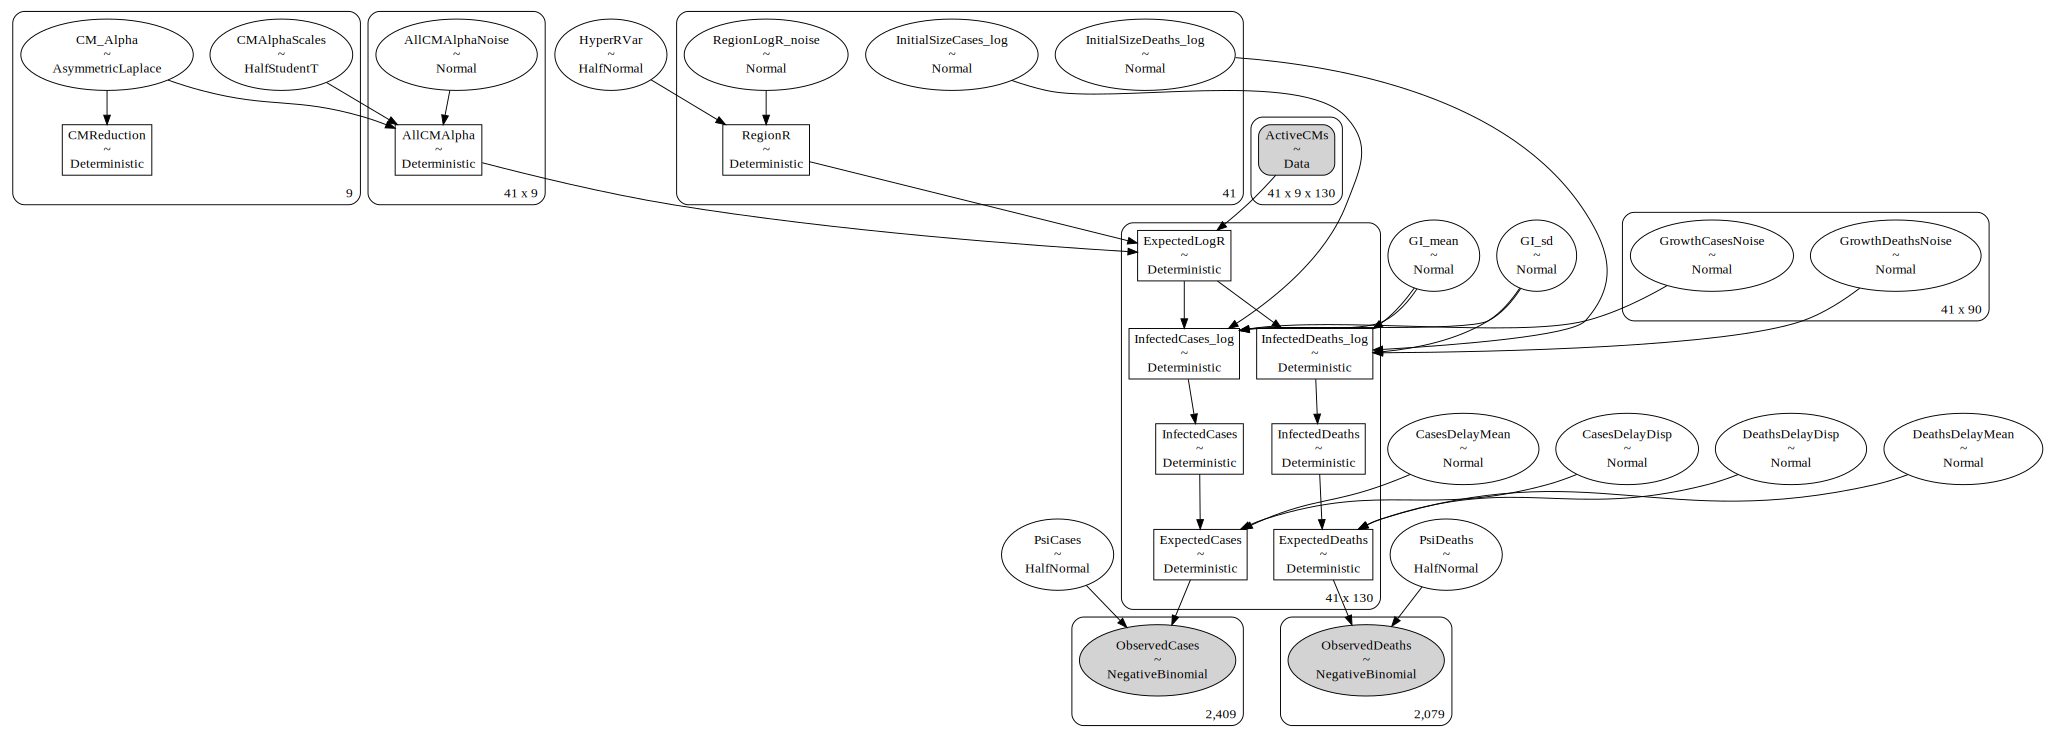

In [7]:
pm.model_to_graphviz(model)

# Note: i've increased target_accept - might improve sampling too. 

In [8]:
with model:
    model.trace = pm.sample(2000, tune=500, cores=4, chains=4, max_treedepth=12, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [DeathsDelayDisp, DeathsDelayMean, InitialSizeDeaths_log, CasesDelayDisp, CasesDelayMean, InitialSizeCases_log, PsiDeaths, PsiCases, GrowthDeathsNoise, GrowthCasesNoise, GI_sd, GI_mean, RegionLogR_noise, HyperRVar, AllCMAlphaNoise, CMAlphaScales, CM_Alpha]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 15919 seconds.
The number of effective samples is smaller than 25% for some parameters.


# Is the inference stable?

In [9]:
import arviz as az

In [10]:
rhat = az.rhat(model.trace)
ess = az.ess(model.trace)

In [11]:
model.trace.varnames

['CM_Alpha',
 'CMAlphaScales_log__',
 'AllCMAlphaNoise',
 'HyperRVar_log__',
 'RegionLogR_noise',
 'GI_mean',
 'GI_sd',
 'GrowthCasesNoise',
 'GrowthDeathsNoise',
 'PsiCases_log__',
 'PsiDeaths_log__',
 'InitialSizeCases_log',
 'CasesDelayMean',
 'CasesDelayDisp',
 'InitialSizeDeaths_log',
 'DeathsDelayMean',
 'DeathsDelayDisp',
 'CMReduction',
 'CMAlphaScales',
 'AllCMAlpha',
 'HyperRVar',
 'RegionR',
 'ExpectedLogR',
 'PsiCases',
 'PsiDeaths',
 'InfectedCases_log',
 'InfectedCases',
 'ExpectedCases',
 'InfectedDeaths_log',
 'InfectedDeaths',
 'ExpectedDeaths']

In [12]:
def collate(stat):
    stat_all = []
    stat_nums = []
    for var in ["CMReduction", "GI_mean", "GI_sd", "GrowthCasesNoise", "GrowthDeathsNoise", "CasesDelayMean", "CasesDelayDisp",
                "InitialSizeDeaths_log", "InitialSizeCases_log", "DeathsDelayMean", "DeathsDelayDisp", "HyperRVar", "PsiCases",
                "PsiDeaths", "InfectedDeaths", "InfectedCases", "ExpectedDeaths", "ExpectedCases", "AllCMAlphaNoise", "AllCMAlpha"]:
        if stat[str(var)].size>1:
            stat_all.append(stat[str(var)].to_dataframe().to_numpy().flatten())
        else:
            stat_nums.append(float(stat[str(var)]))
    stat_all = np.concatenate(np.array(stat_all))
    stat_all = np.concatenate([stat_all, stat_nums])
#     stat_all[stat_all > 100] = 1
    return stat_all

In [14]:
import matplotlib.pyplot as plt

<ipython-input-12-7a0f31ac7464>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  stat_all = np.concatenate(np.array(stat_all))


Text(0.5, 1.0, 'Relative ESS')

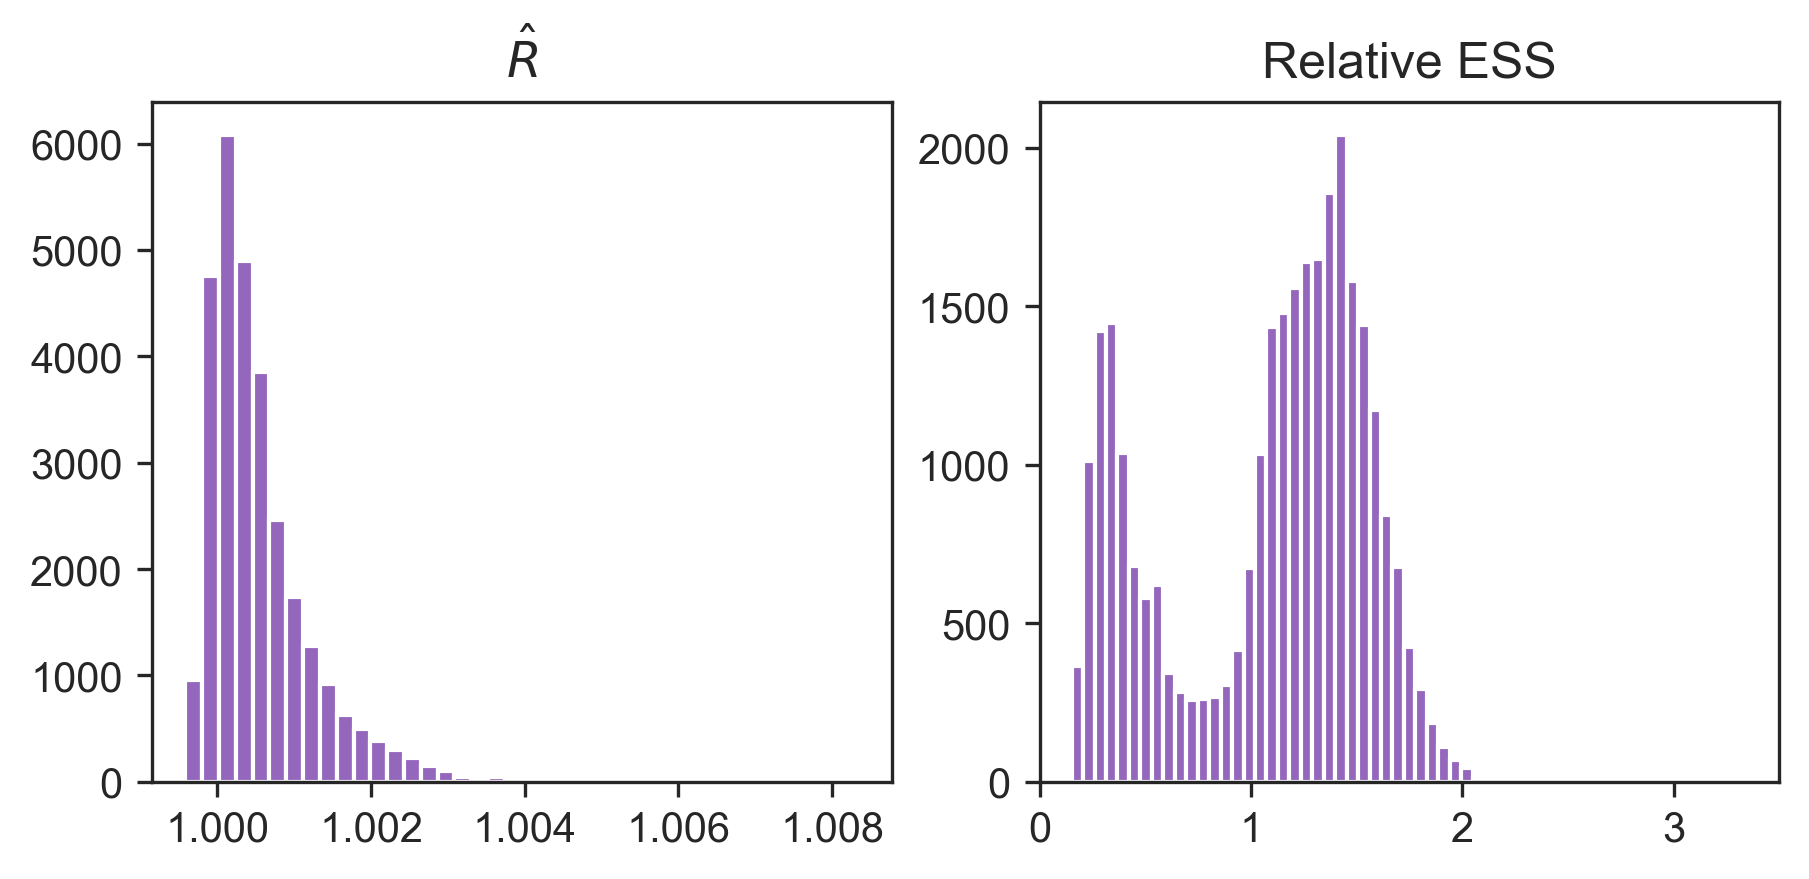

In [15]:
plt.figure(figsize=(7, 3), dpi=300)
plt.subplot(121)
plt.hist(collate(rhat), bins=40, color='tab:purple')
plt.title("$\hat{R}$", fontsize=12)

plt.subplot(122)
plt.hist(collate(ess)/8000, bins=40, color='tab:purple')
plt.xlim([0, 3.5])
plt.title("Relative ESS", fontsize=12)

$\hat{R}$ looks okay, ESS looks somewhat troubling .... inspect in more detail

In [16]:
rhat

<xarray.Dataset>
Dimensions:                      (AllCMAlphaNoise_dim_0: 41, AllCMAlphaNoise_dim_1: 9, AllCMAlpha_dim_0: 41, AllCMAlpha_dim_1: 9, CMAlphaScales_dim_0: 9, CMReduction_dim_0: 9, CM_Alpha_dim_0: 9, ExpectedCases_dim_0: 41, ExpectedCases_dim_1: 130, ExpectedDeaths_dim_0: 41, ExpectedDeaths_dim_1: 130, ExpectedLogR_dim_0: 41, ExpectedLogR_dim_1: 130, GrowthCasesNoise_dim_0: 41, GrowthCasesNoise_dim_1: 90, GrowthDeathsNoise_dim_0: 41, GrowthDeathsNoise_dim_1: 90, InfectedCases_dim_0: 41, InfectedCases_dim_1: 130, InfectedCases_log_dim_0: 41, InfectedCases_log_dim_1: 130, InfectedDeaths_dim_0: 41, InfectedDeaths_dim_1: 130, InfectedDeaths_log_dim_0: 41, InfectedDeaths_log_dim_1: 130, InitialSizeCases_log_dim_0: 41, InitialSizeDeaths_log_dim_0: 41, RegionLogR_noise_dim_0: 41, RegionR_dim_0: 41)
Coordinates:
  * CM_Alpha_dim_0               (CM_Alpha_dim_0) int64 0 1 2 3 4 5 6 7 8
  * AllCMAlphaNoise_dim_0        (AllCMAlphaNoise_dim_0) int64 0 1 2 ... 39 40
  * AllCMAlphaNoise_dim_1        (AllCMAlphaNoise_dim_1) int64 0 1 2 3 4 5 6 7 8
  * RegionLogR_noise_dim_0       (RegionLogR_noise_dim_0) int64 0 1 2 ... 39 40
  * GrowthCasesNoise_dim_0       (GrowthCasesNoise_dim_0) int64 0 1 2 ... 39 40
  * GrowthCasesNoise_dim_1       (GrowthCasesNoise_dim_1) int64 0 1 2 ... 88 89
  * GrowthDeathsNoise_dim_0      (GrowthDeathsNoise_dim_0) int64 0 1 2 ... 39 40
  * GrowthDeathsNoise_dim_1      (GrowthDeathsNoise_dim_1) int64 0 1 2 ... 88 89
  * InitialSizeCases_log_dim_0   (InitialSizeCases_log_dim_0) int64 0 1 ... 40
  * InitialSizeDeaths_log_dim_0  (InitialSizeDeaths_log_dim_0) int64 0 1 ... 40
  * CMReduction_dim_0            (CMReduction_dim_0) int64 0 1 2 3 4 5 6 7 8
  * CMAlphaScales_dim_0          (CMAlphaScales_dim_0) int64 0 1 2 3 4 5 6 7 8
  * AllCMAlpha_dim_0             (AllCMAlpha_dim_0) int64 0 1 2 3 ... 38 39 40
  * AllCMAlpha_dim_1             (AllCMAlpha_dim_1) int64 0 1 2 3 4 5 6 7 8
  * RegionR_dim_0                (RegionR_dim_0) int64 0 1 2 3 4 ... 37 38 39 40
  * ExpectedLogR_dim_0           (ExpectedLogR_dim_0) int64 0 1 2 3 ... 38 39 40
  * ExpectedLogR_dim_1           (ExpectedLogR_dim_1) int64 0 1 2 ... 128 129
  * InfectedCases_log_dim_0      (InfectedCases_log_dim_0) int64 0 1 2 ... 39 40
  * InfectedCases_log_dim_1      (InfectedCases_log_dim_1) int64 0 1 ... 128 129
  * InfectedCases_dim_0          (InfectedCases_dim_0) int64 0 1 2 ... 38 39 40
  * InfectedCases_dim_1          (InfectedCases_dim_1) int64 0 1 2 ... 128 129
  * ExpectedCases_dim_0          (ExpectedCases_dim_0) int64 0 1 2 ... 38 39 40
  * ExpectedCases_dim_1          (ExpectedCases_dim_1) int64 0 1 2 ... 128 129
  * InfectedDeaths_log_dim_0     (InfectedDeaths_log_dim_0) int64 0 1 ... 39 40
  * InfectedDeaths_log_dim_1     (InfectedDeaths_log_dim_1) int64 0 1 ... 129
  * InfectedDeaths_dim_0         (InfectedDeaths_dim_0) int64 0 1 2 ... 38 39 40
  * InfectedDeaths_dim_1         (InfectedDeaths_dim_1) int64 0 1 2 ... 128 129
  * ExpectedDeaths_dim_0         (ExpectedDeaths_dim_0) int64 0 1 2 ... 38 39 40
  * ExpectedDeaths_dim_1         (ExpectedDeaths_dim_1) int64 0 1 2 ... 128 129
Data variables:
    CM_Alpha                     (CM_Alpha_dim_0) float64 1.001 1.001 ... 1.001
    AllCMAlphaNoise              (AllCMAlphaNoise_dim_0, AllCMAlphaNoise_dim_1) float64 ...
    RegionLogR_noise             (RegionLogR_noise_dim_0) float64 1.001 ... 1...
    GI_mean                      float64 1.002
    GI_sd                        float64 1.002
    GrowthCasesNoise             (GrowthCasesNoise_dim_0, GrowthCasesNoise_dim_1) float64 ...
    GrowthDeathsNoise            (GrowthDeathsNoise_dim_0, GrowthDeathsNoise_dim_1) float64 ...
    InitialSizeCases_log         (InitialSizeCases_log_dim_0) float64 1.001 ....
    CasesDelayMean               float64 1.0
    CasesDelayDisp               float64 1.001
    InitialSizeDeaths_log        (InitialSizeDeaths_log_dim_0) float64 1.001 ...
    DeathsDelayMean              float64 0.9998
    DeathsD

# $\hat{R}$ issues

I suspected that the sampling would be stable. Its much better than expected, but we have slightly high $\hat{R}$ for the individual $\alpha_{i,c}$, as well as the scales. 

The important thing is not having too many divergences. No divergences is good - I think we'd just want to run this for more samples. 

In [17]:
ess

<xarray.Dataset>
Dimensions:                      (AllCMAlphaNoise_dim_0: 41, AllCMAlphaNoise_dim_1: 9, AllCMAlpha_dim_0: 41, AllCMAlpha_dim_1: 9, CMAlphaScales_dim_0: 9, CMReduction_dim_0: 9, CM_Alpha_dim_0: 9, ExpectedCases_dim_0: 41, ExpectedCases_dim_1: 130, ExpectedDeaths_dim_0: 41, ExpectedDeaths_dim_1: 130, ExpectedLogR_dim_0: 41, ExpectedLogR_dim_1: 130, GrowthCasesNoise_dim_0: 41, GrowthCasesNoise_dim_1: 90, GrowthDeathsNoise_dim_0: 41, GrowthDeathsNoise_dim_1: 90, InfectedCases_dim_0: 41, InfectedCases_dim_1: 130, InfectedCases_log_dim_0: 41, InfectedCases_log_dim_1: 130, InfectedDeaths_dim_0: 41, InfectedDeaths_dim_1: 130, InfectedDeaths_log_dim_0: 41, InfectedDeaths_log_dim_1: 130, InitialSizeCases_log_dim_0: 41, InitialSizeDeaths_log_dim_0: 41, RegionLogR_noise_dim_0: 41, RegionR_dim_0: 41)
Coordinates:
  * CM_Alpha_dim_0               (CM_Alpha_dim_0) int64 0 1 2 3 4 5 6 7 8
  * AllCMAlphaNoise_dim_0        (AllCMAlphaNoise_dim_0) int64 0 1 2 ... 39 40
  * AllCMAlphaNoise_dim_1        (AllCMAlphaNoise_dim_1) int64 0 1 2 3 4 5 6 7 8
  * RegionLogR_noise_dim_0       (RegionLogR_noise_dim_0) int64 0 1 2 ... 39 40
  * GrowthCasesNoise_dim_0       (GrowthCasesNoise_dim_0) int64 0 1 2 ... 39 40
  * GrowthCasesNoise_dim_1       (GrowthCasesNoise_dim_1) int64 0 1 2 ... 88 89
  * GrowthDeathsNoise_dim_0      (GrowthDeathsNoise_dim_0) int64 0 1 2 ... 39 40
  * GrowthDeathsNoise_dim_1      (GrowthDeathsNoise_dim_1) int64 0 1 2 ... 88 89
  * InitialSizeCases_log_dim_0   (InitialSizeCases_log_dim_0) int64 0 1 ... 40
  * InitialSizeDeaths_log_dim_0  (InitialSizeDeaths_log_dim_0) int64 0 1 ... 40
  * CMReduction_dim_0            (CMReduction_dim_0) int64 0 1 2 3 4 5 6 7 8
  * CMAlphaScales_dim_0          (CMAlphaScales_dim_0) int64 0 1 2 3 4 5 6 7 8
  * AllCMAlpha_dim_0             (AllCMAlpha_dim_0) int64 0 1 2 3 ... 38 39 40
  * AllCMAlpha_dim_1             (AllCMAlpha_dim_1) int64 0 1 2 3 4 5 6 7 8
  * RegionR_dim_0                (RegionR_dim_0) int64 0 1 2 3 4 ... 37 38 39 40
  * ExpectedLogR_dim_0           (ExpectedLogR_dim_0) int64 0 1 2 3 ... 38 39 40
  * ExpectedLogR_dim_1           (ExpectedLogR_dim_1) int64 0 1 2 ... 128 129
  * InfectedCases_log_dim_0      (InfectedCases_log_dim_0) int64 0 1 2 ... 39 40
  * InfectedCases_log_dim_1      (InfectedCases_log_dim_1) int64 0 1 ... 128 129
  * InfectedCases_dim_0          (InfectedCases_dim_0) int64 0 1 2 ... 38 39 40
  * InfectedCases_dim_1          (InfectedCases_dim_1) int64 0 1 2 ... 128 129
  * ExpectedCases_dim_0          (ExpectedCases_dim_0) int64 0 1 2 ... 38 39 40
  * ExpectedCases_dim_1          (ExpectedCases_dim_1) int64 0 1 2 ... 128 129
  * InfectedDeaths_log_dim_0     (InfectedDeaths_log_dim_0) int64 0 1 ... 39 40
  * InfectedDeaths_log_dim_1     (InfectedDeaths_log_dim_1) int64 0 1 ... 129
  * InfectedDeaths_dim_0         (InfectedDeaths_dim_0) int64 0 1 2 ... 38 39 40
  * InfectedDeaths_dim_1         (InfectedDeaths_dim_1) int64 0 1 2 ... 128 129
  * ExpectedDeaths_dim_0         (ExpectedDeaths_dim_0) int64 0 1 2 ... 38 39 40
  * ExpectedDeaths_dim_1         (ExpectedDeaths_dim_1) int64 0 1 2 ... 128 129
Data variables:
    CM_Alpha                     (CM_Alpha_dim_0) float64 5.818e+03 ... 2.828...
    AllCMAlphaNoise              (AllCMAlphaNoise_dim_0, AllCMAlphaNoise_dim_1) float64 ...
    RegionLogR_noise             (RegionLogR_noise_dim_0) float64 3.423e+03 ....
    GI_mean                      float64 2.054e+03
    GI_sd                        float64 1.852e+03
    GrowthCasesNoise             (GrowthCasesNoise_dim_0, GrowthCasesNoise_dim_1) float64 ...
    GrowthDeathsNoise            (GrowthDeathsNoise_dim_0, GrowthDeathsNoise_dim_1) float64 ...
    InitialSizeCases_log         (InitialSizeCases_log_dim_0) float64 2.346e+...
    CasesDelayMean               float64 3.069e+03
    CasesDelayDisp               float64 1.001e+04
    InitialSizeDeaths_log        (InitialSizeDeaths_log_dim_0) float64 2.277e...
    DeathsDelayMean              float64

# ESS issues!

Similar issue with the effective sample size - note that we only have 23 *effective* samples for the School Closure NPI. I have a few thoughts on improving this though - the inference is better than I originally expected. 

This means that sampler is having some difficulty sampling these parameters, and the trace has high autocorrelation. 

# Are the traces bad?

array([[<AxesSubplot:title={'center':'CMAlphaScales\n0'}>,
        <AxesSubplot:title={'center':'CMAlphaScales\n0'}>],
       [<AxesSubplot:title={'center':'CMAlphaScales\n1'}>,
        <AxesSubplot:title={'center':'CMAlphaScales\n1'}>],
       [<AxesSubplot:title={'center':'CMAlphaScales\n2'}>,
        <AxesSubplot:title={'center':'CMAlphaScales\n2'}>],
       [<AxesSubplot:title={'center':'CMAlphaScales\n3'}>,
        <AxesSubplot:title={'center':'CMAlphaScales\n3'}>],
       [<AxesSubplot:title={'center':'CMAlphaScales\n4'}>,
        <AxesSubplot:title={'center':'CMAlphaScales\n4'}>],
       [<AxesSubplot:title={'center':'CMAlphaScales\n5'}>,
        <AxesSubplot:title={'center':'CMAlphaScales\n5'}>],
       [<AxesSubplot:title={'center':'CMAlphaScales\n6'}>,
        <AxesSubplot:title={'center':'CMAlphaScales\n6'}>],
       [<AxesSubplot:title={'center':'CMAlphaScales\n7'}>,
        <AxesSubplot:title={'center':'CMAlphaScales\n7'}>],
       [<AxesSubplot:title={'center':'CMAlphaSca

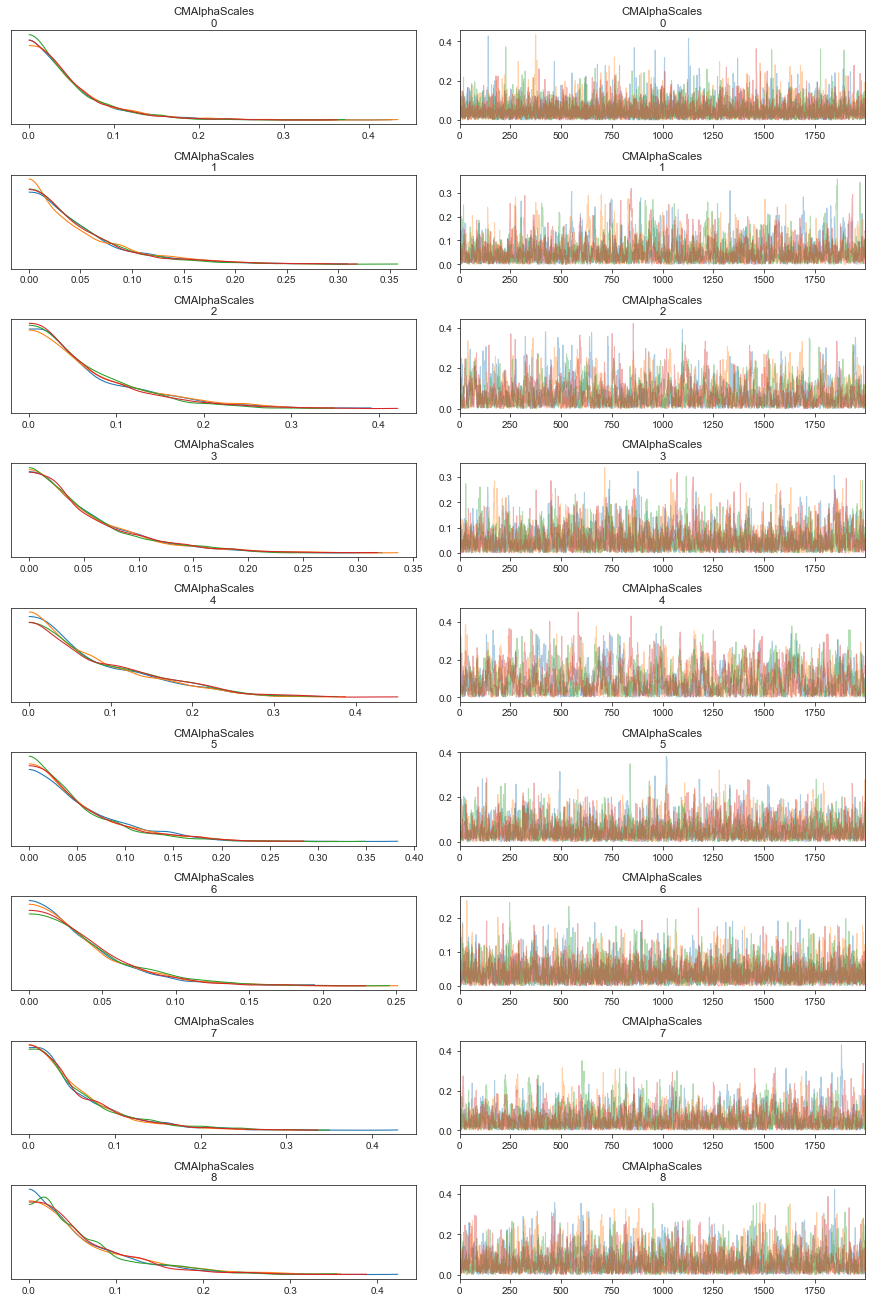

In [18]:
az.plot_trace(model.trace, var_names=['CMAlphaScales'])

Indeed, inspecting the above traces, we see very high autocorrelation (look at the right plots). The density estimates for the different traces also looks pretty different. 

If anybody see these traces, they'll tell you that the are probably garbage. 

I have some ideas as to how to fix this though. 

# Preliminary results analysis

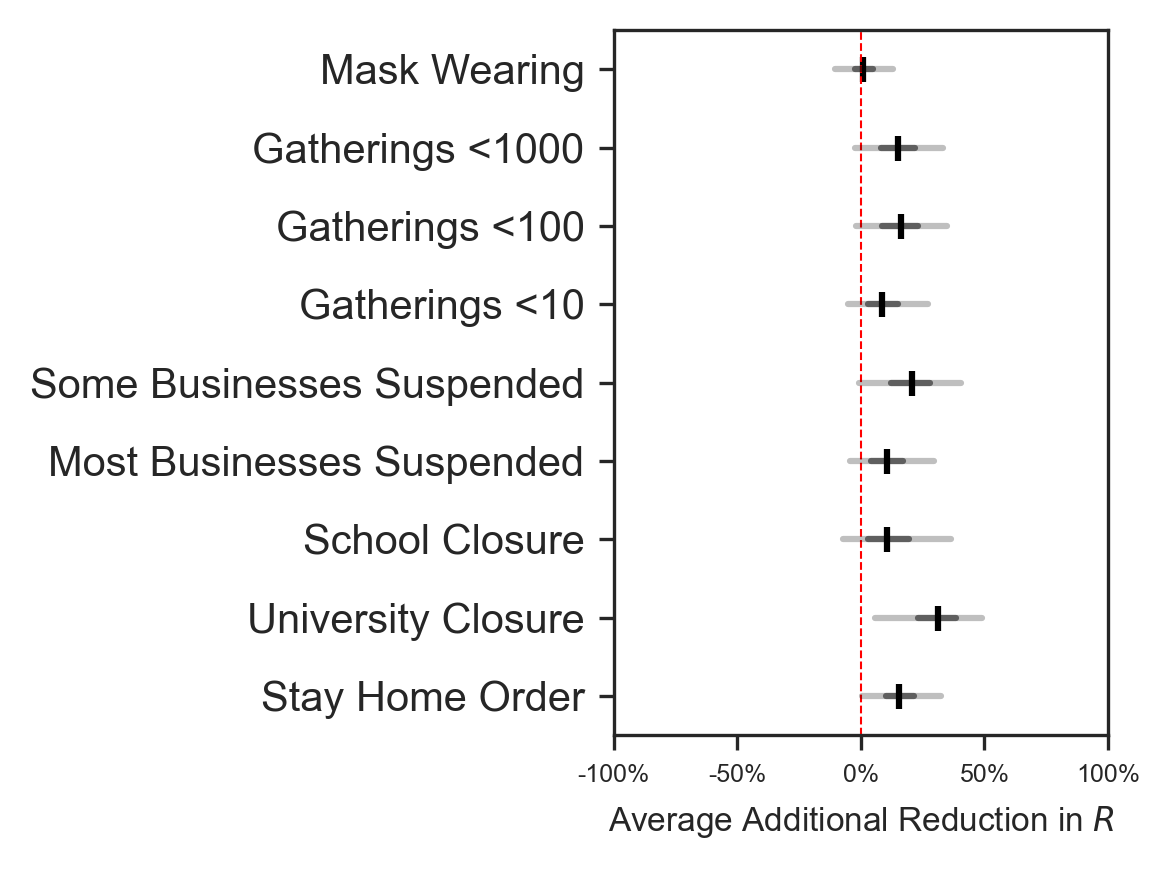

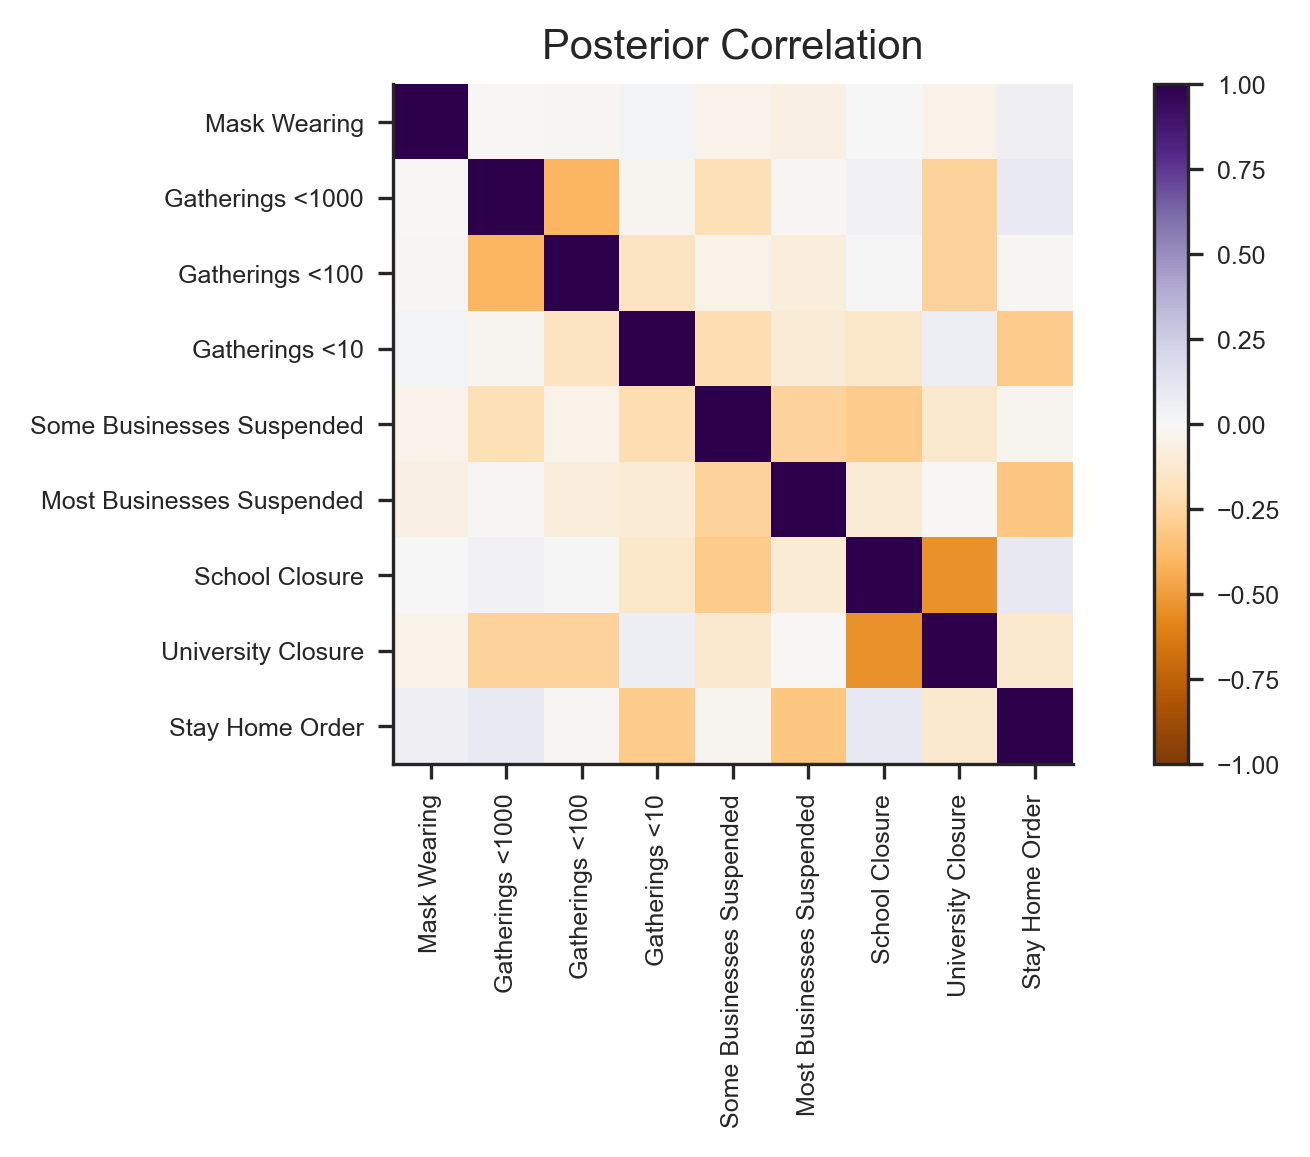

In [19]:
model.plot_effect()

Results similar to that expected, not too big of a difference

## What alpha noise do we learn?

Text(0.5, 1.0, 'NPI Region Variability')

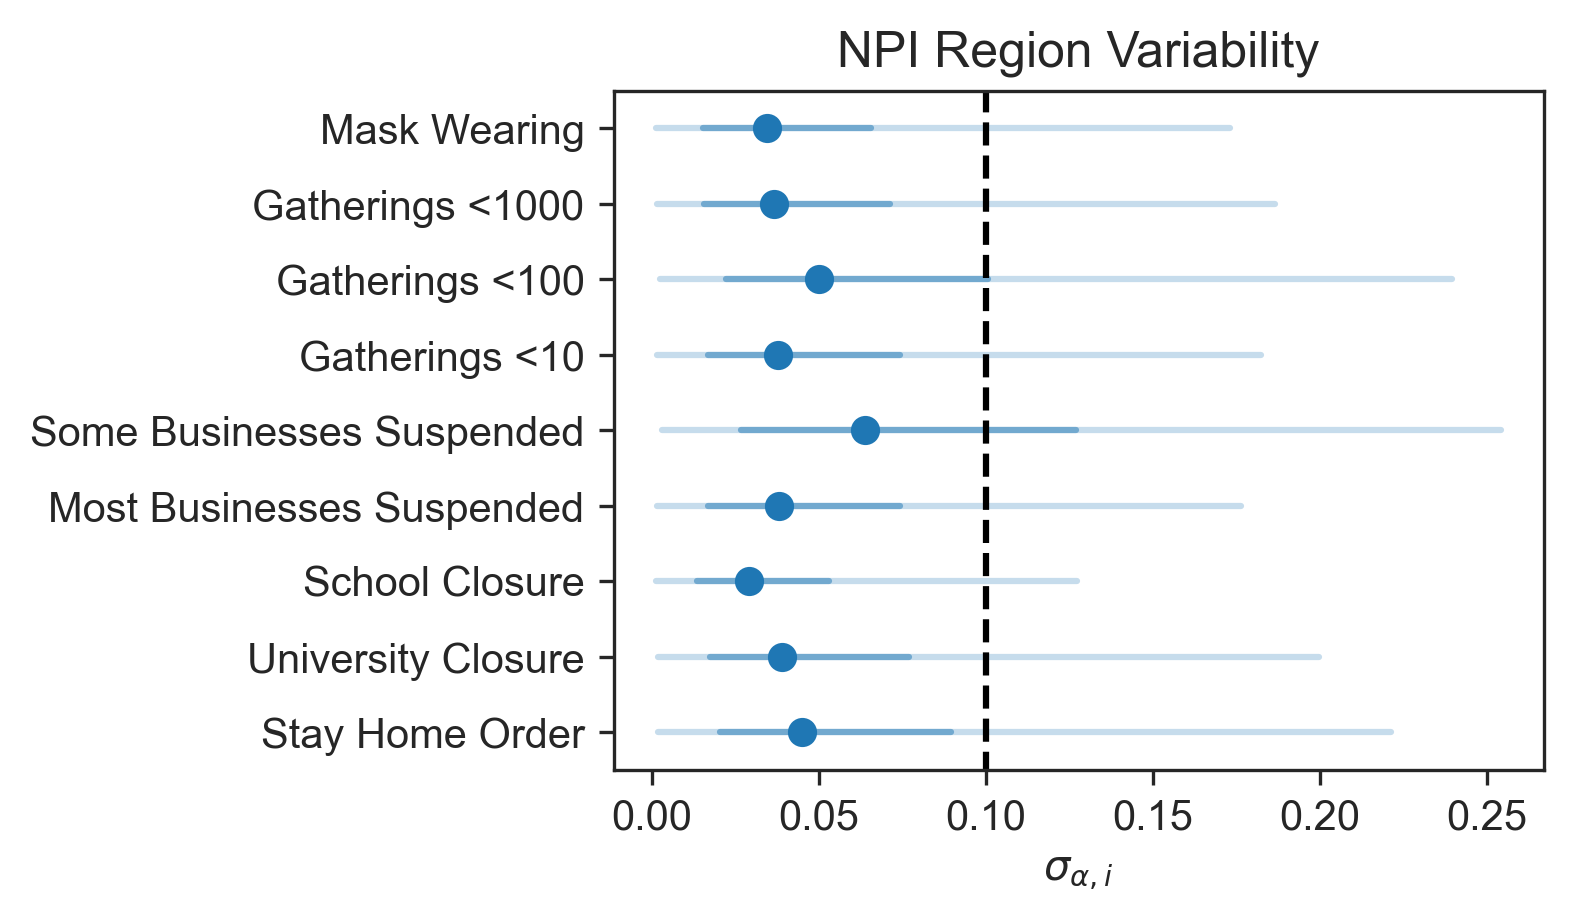

In [20]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(4, 3), dpi=300)

plt.scatter(np.percentile(model.trace.CMAlphaScales, 50, axis=0), -np.arange(9))

for i in range(9):
    plt.plot([np.percentile(model.trace.CMAlphaScales[:, i], 2.5), np.percentile(model.trace.CMAlphaScales[:, i], 97.5)], [-i, -i], color='tab:blue', alpha=0.25)
    plt.plot([np.percentile(model.trace.CMAlphaScales[:, i], 25), np.percentile(model.trace.CMAlphaScales[:, i], 75)], [-i, -i], color='tab:blue', alpha=0.5)

plt.plot([0.1, 0.1], [-9, 5], 'k--')

plt.ylim([-8.5, 0.5])
plt.yticks(-np.arange(9), data.CMs)
plt.xlabel('$\sigma_{\\alpha, i}$')
plt.title('NPI Region Variability')

# What does this actually look like, uncertainty wise?

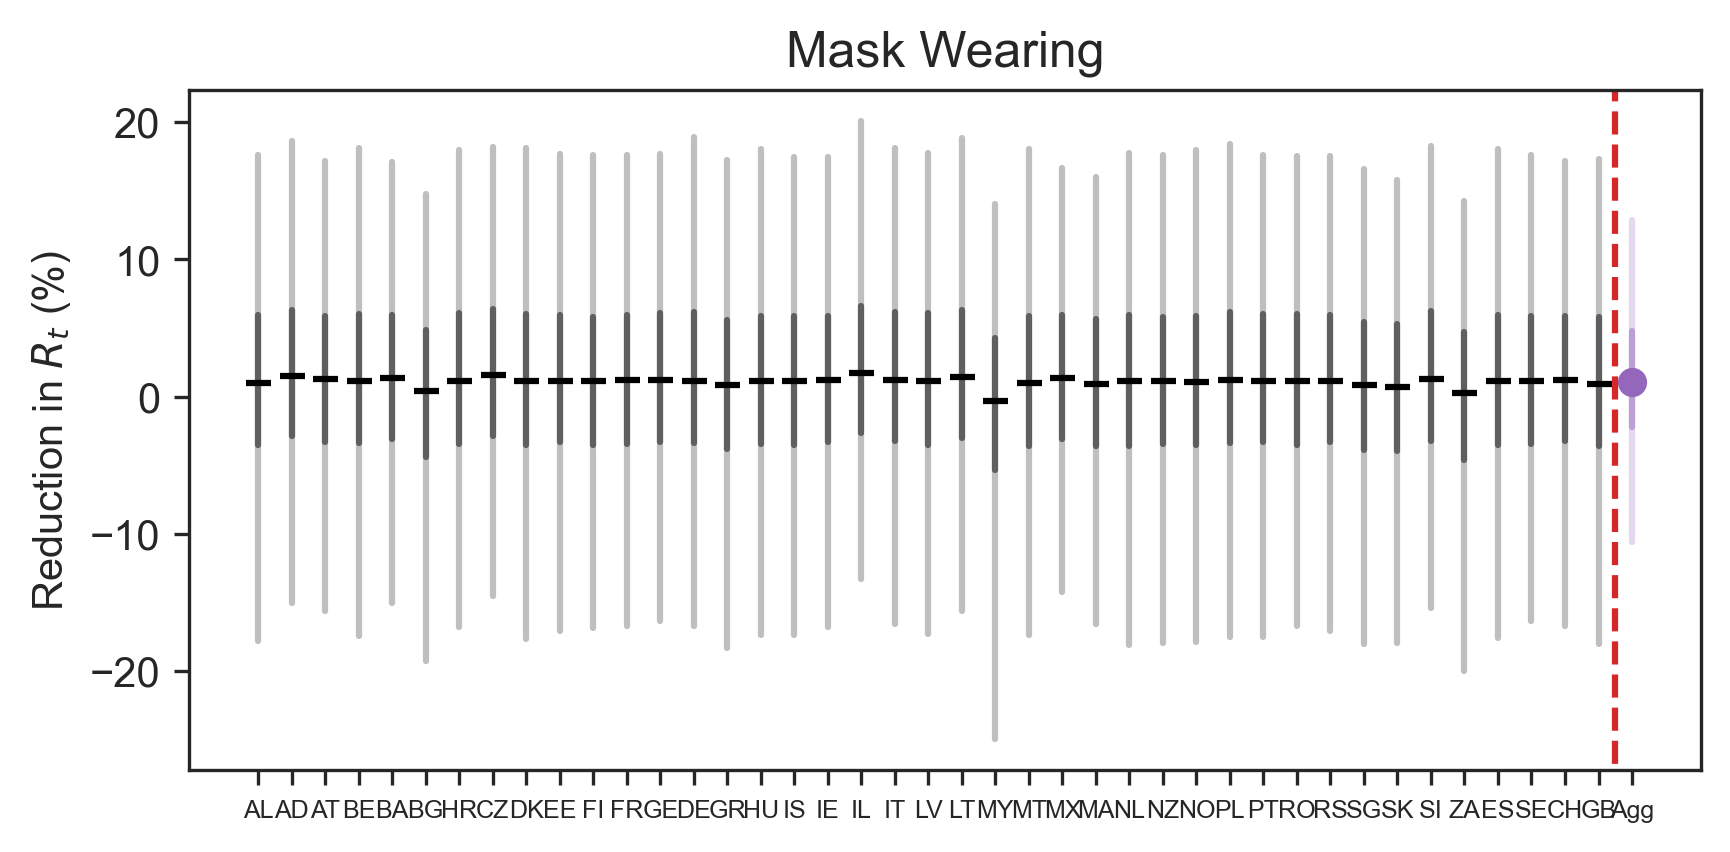

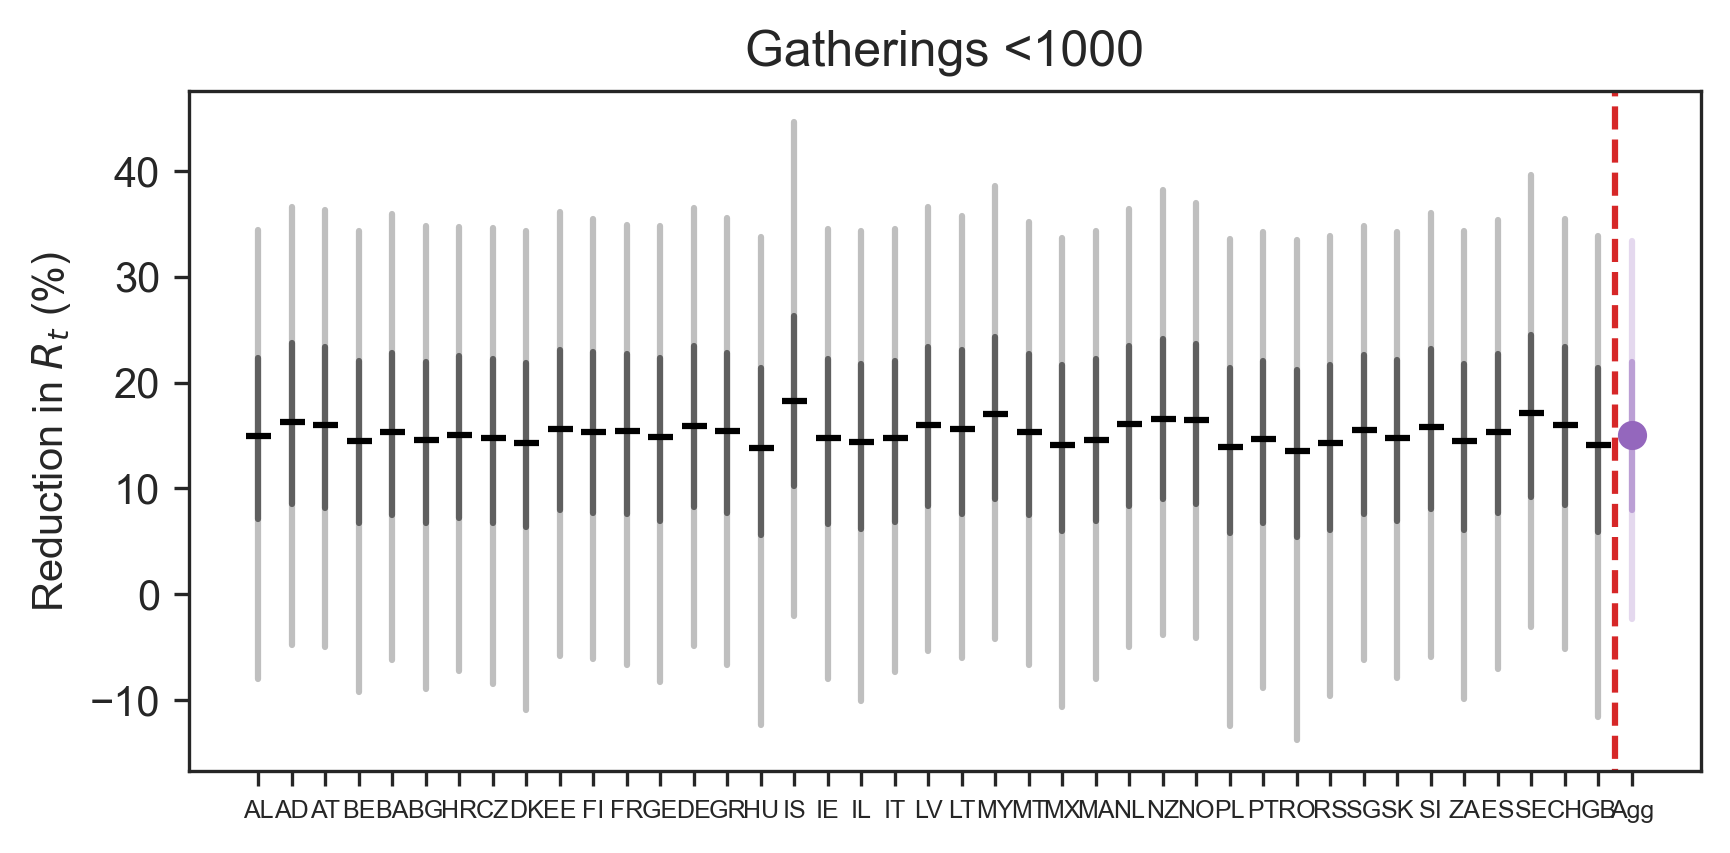

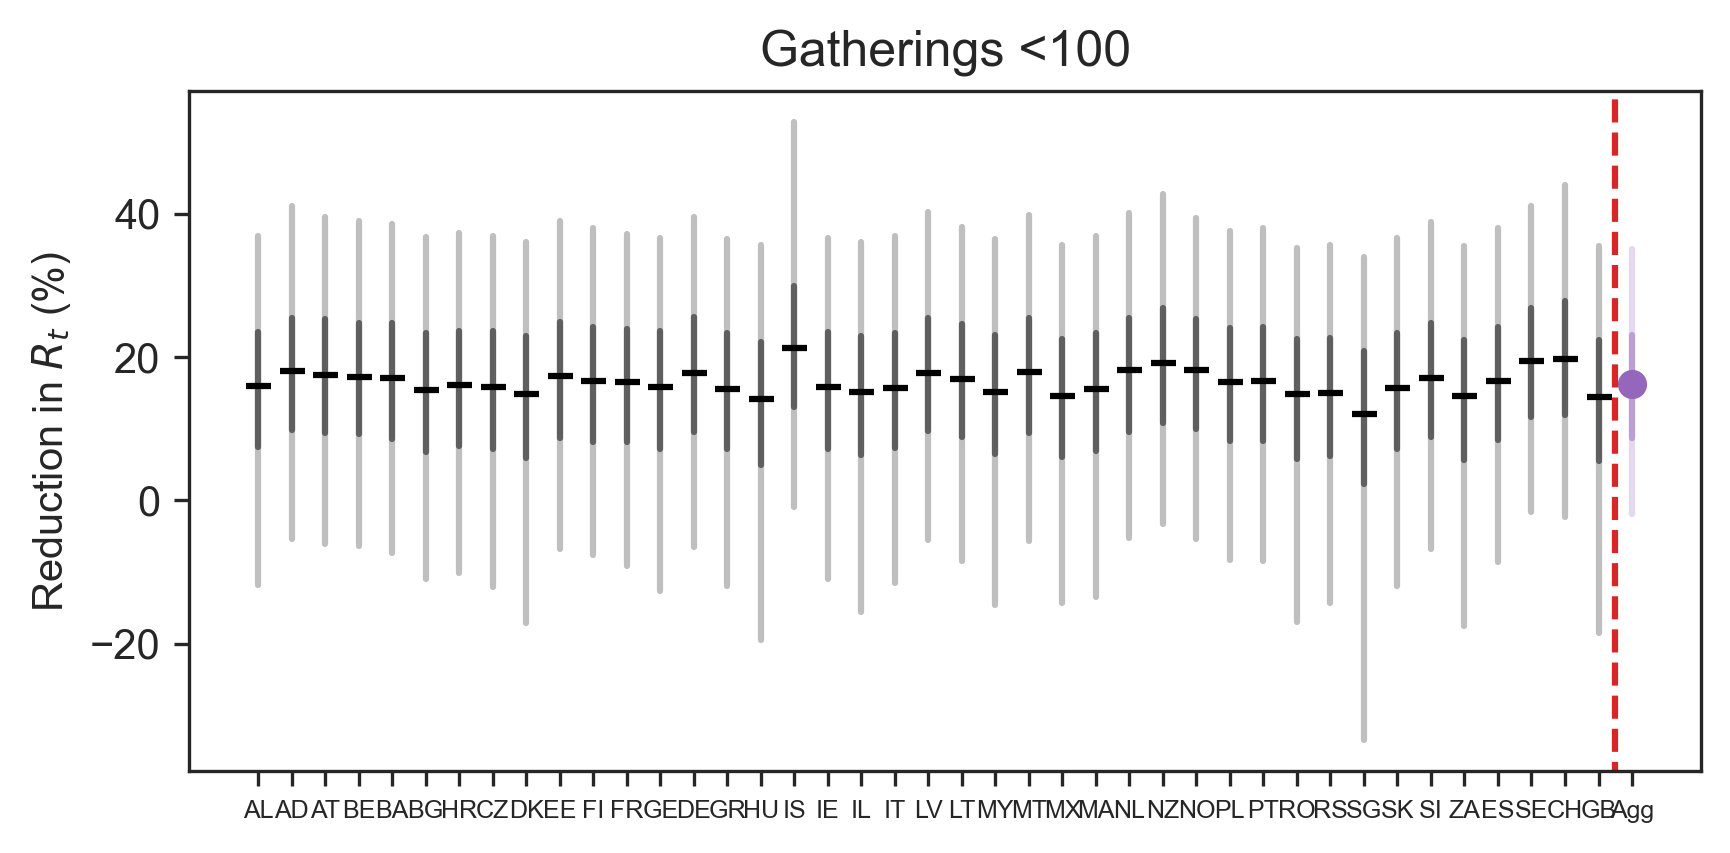

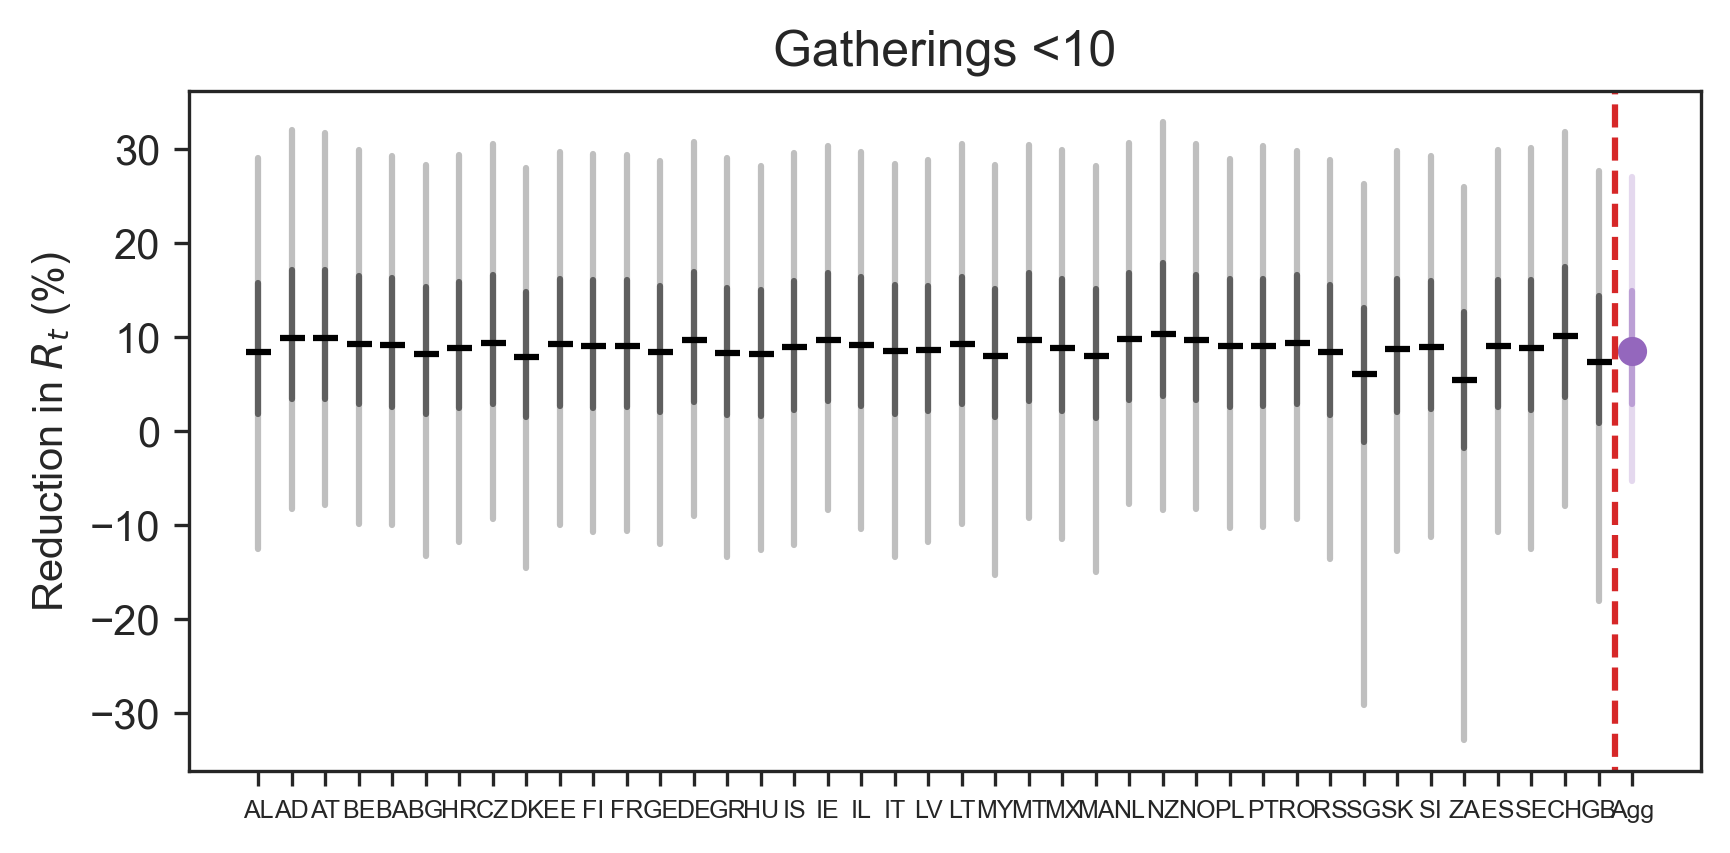

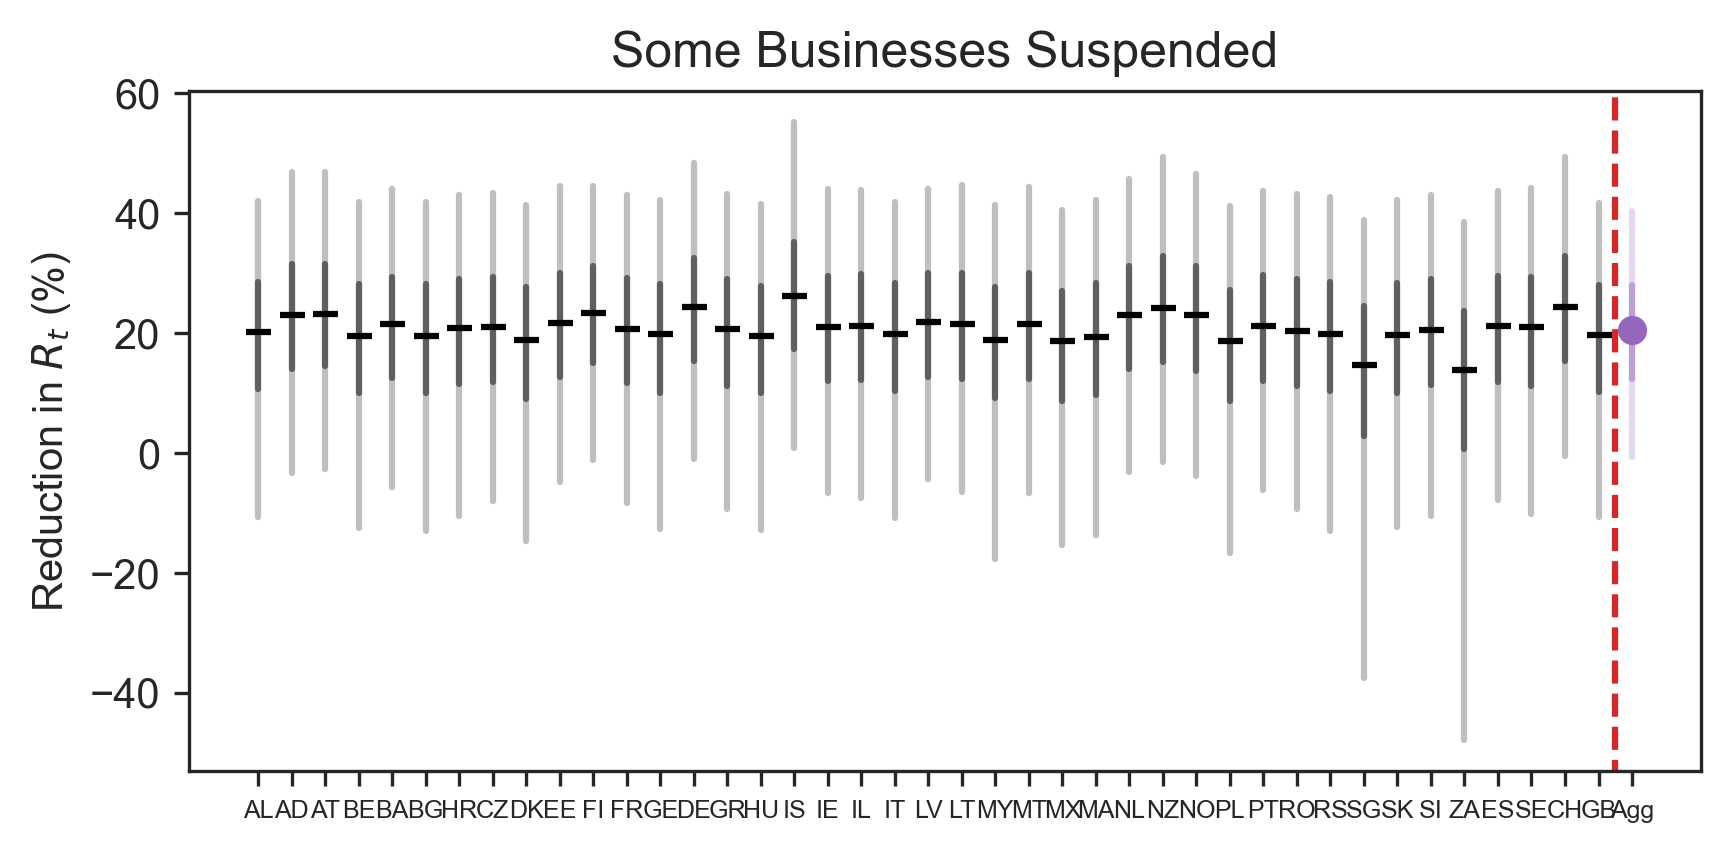

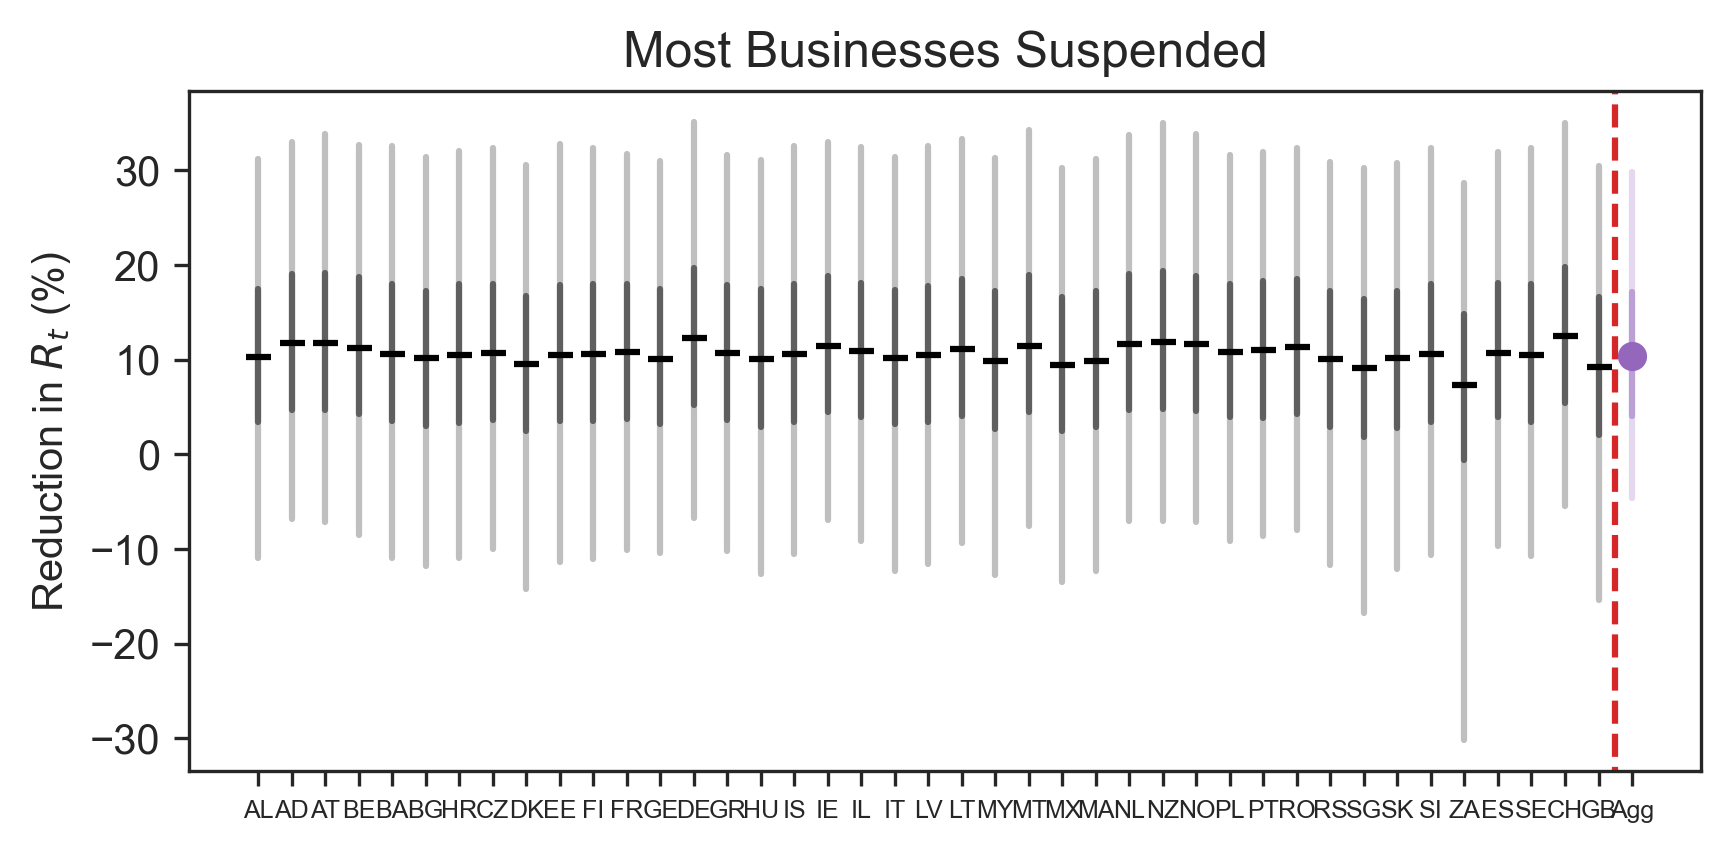

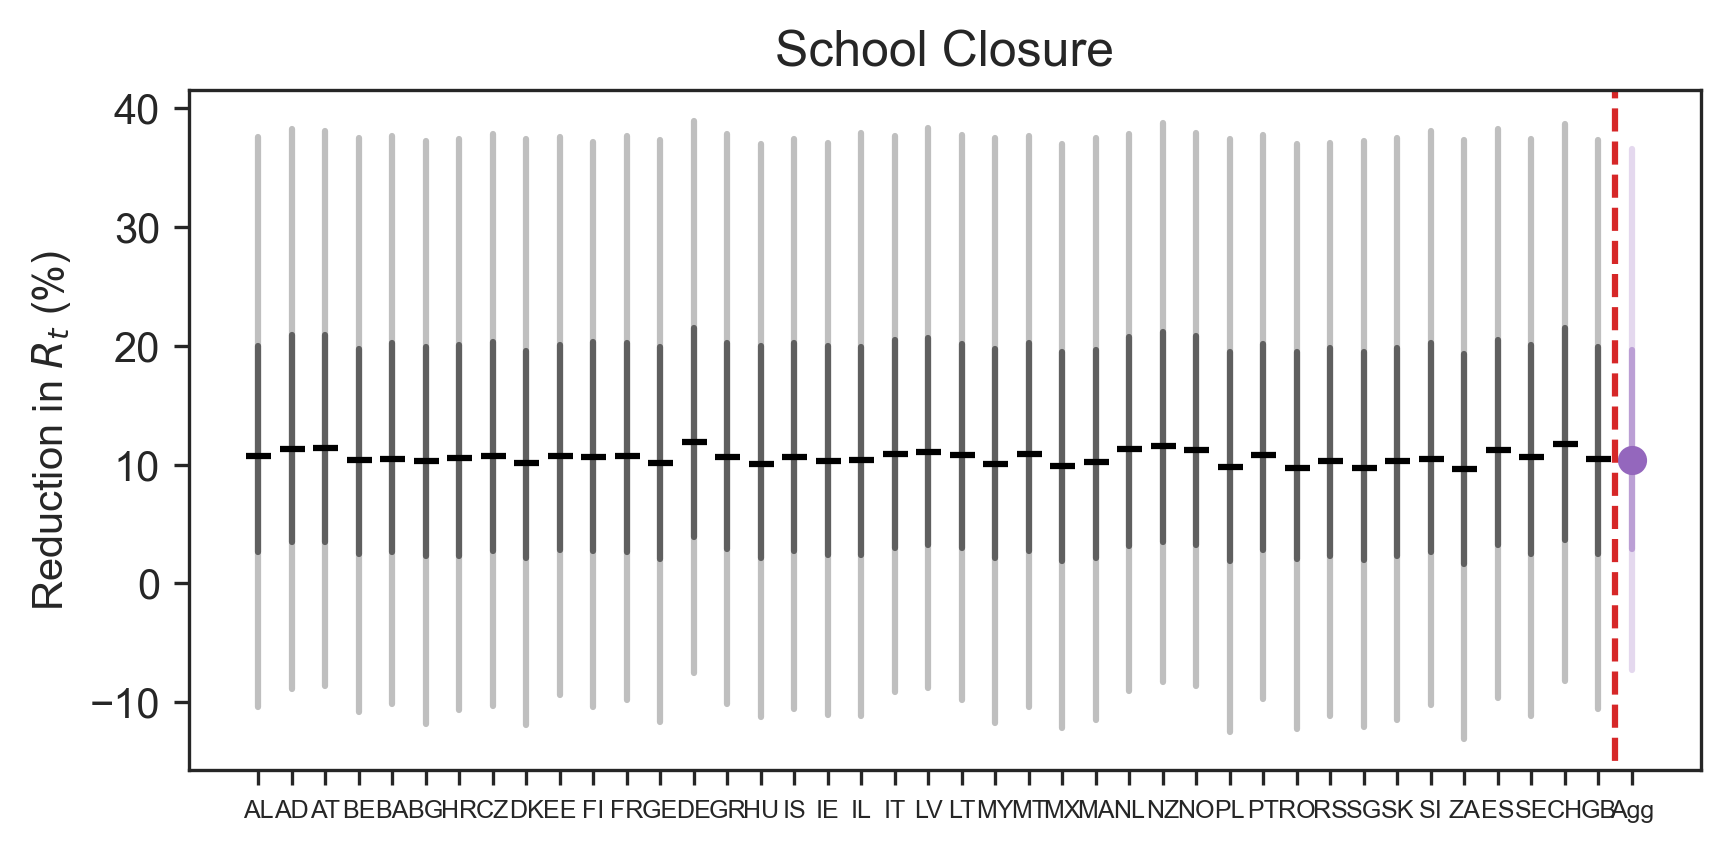

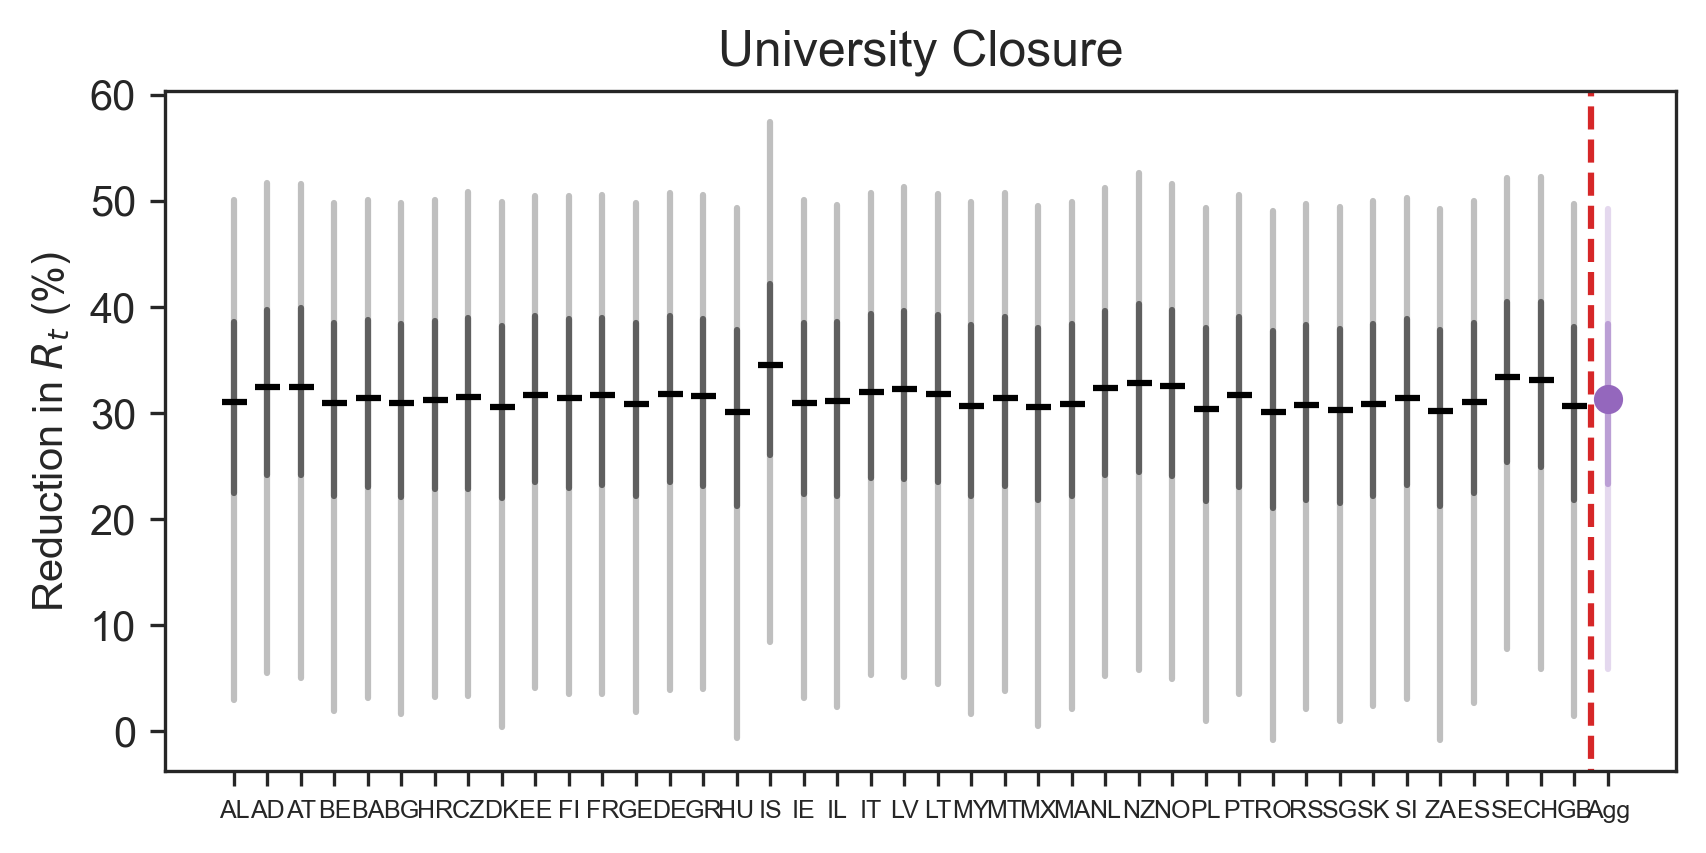

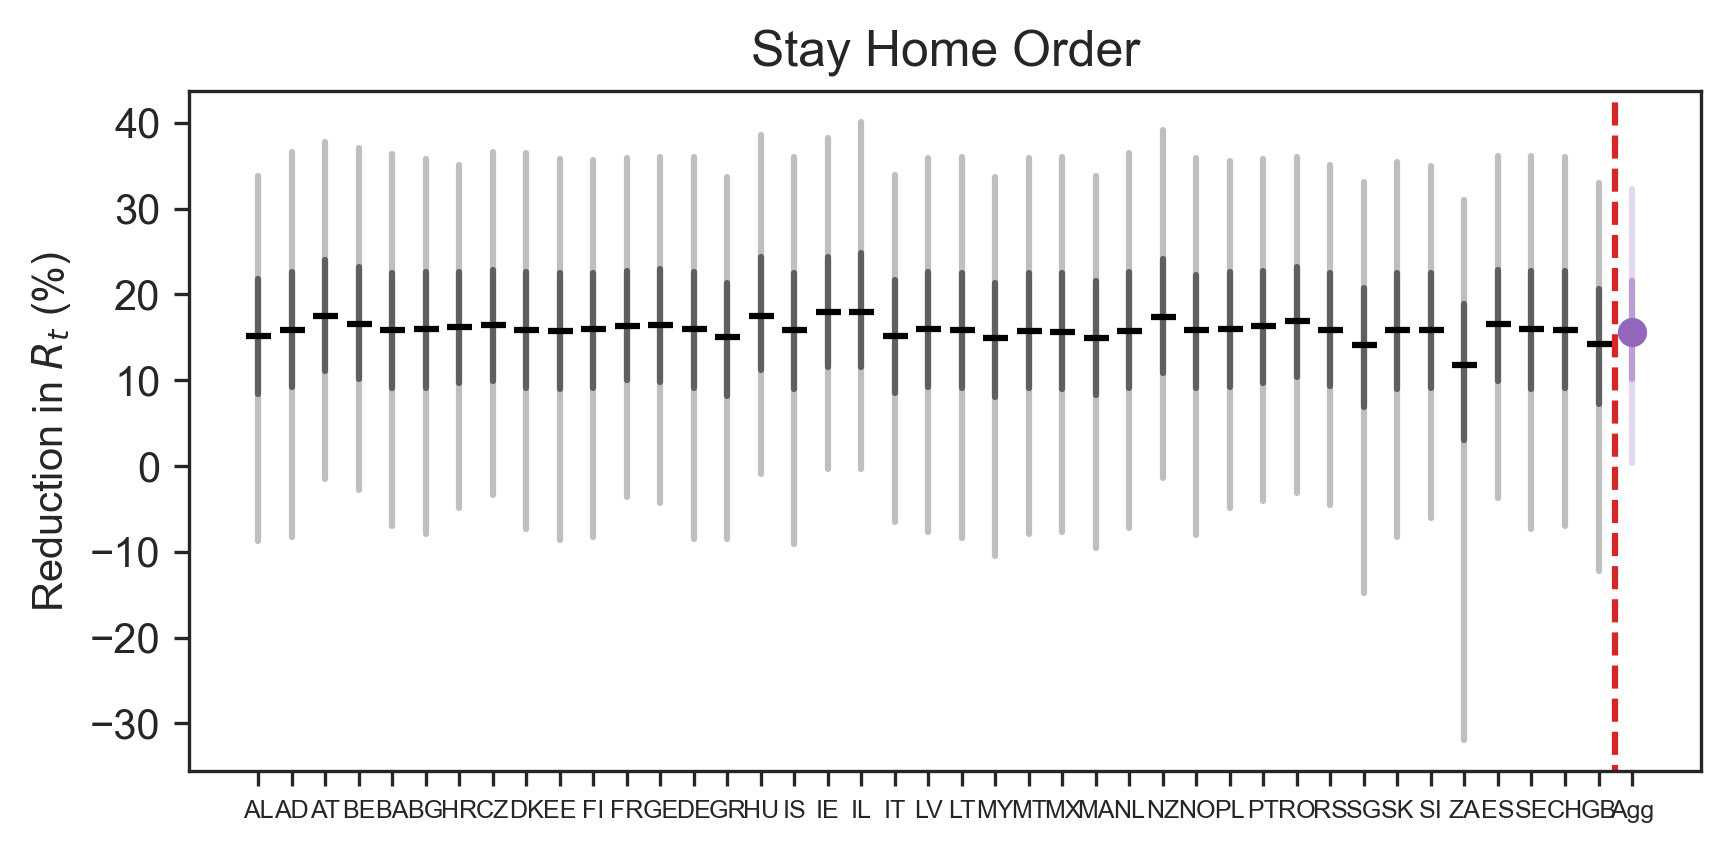

In [21]:
for i in range(9):
    plt.figure(figsize=(6.5, 3), dpi=300)
    for r in range(len(data.Rs)):
        perred = 100*(1-np.exp(-model.trace.AllCMAlpha[:, r, i]))
        plt.plot([r, r], [np.percentile(perred, 2.5, axis=0), np.percentile(perred, 97.5, axis=0)], color='k', alpha=0.25)
        plt.plot([r, r], [np.percentile(perred, 25, axis=0), np.percentile(perred, 75, axis=0)], color='k', alpha=0.5)
        plt.scatter(r, np.median(perred), color='k', marker='_')
    
    plt.ylabel('Reduction in $R_t$ (%)')
    y_min, y_max = plt.ylim()
    plt.plot([len(data.Rs)-0.5, len(data.Rs)-0.5], [y_min-2, y_max+2], '--', color='tab:red')
    plt.ylim([y_min, y_max])
    
    overall_red = 100*(1-model.trace.CMReduction[:, i])
    plt.scatter(len(data.Rs), np.median(overall_red), color='tab:purple')
    plt.plot([len(data.Rs), len(data.Rs)], [np.percentile(overall_red, 2.5), np.percentile(overall_red, 97.5)],  color='tab:purple', alpha=0.25)
    plt.plot([len(data.Rs), len(data.Rs)], [np.percentile(overall_red, 25), np.percentile(overall_red, 75)], color='tab:purple', alpha=0.5)
    plt.title(data.CMs[i])
    plt.xticks(np.arange(len(data.Rs)+1), [*data.Rs, 'Agg'], fontsize=6)

In [22]:
import pickle

pickle.dump(model.trace, open('traces/complexdiffeffv2.pkl', 'wb'))